In [ ]:
# Essential imports for image work with NumPy in a Jupyter cell
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [ ]:
def read_image(path, as_gray=False):
    """
    Read image from path and return a NumPy array.
    - Colored images are returned as RGB uint8 arrays.
    - If as_gray=True, returns a single-channel uint8 array.
    Raises FileNotFoundError if the path is invalid.
    """
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")

    # If grayscale requested
    if as_gray:
        if img.ndim == 3:
            return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return img

    # If already single channel, return as-is
    if img.ndim == 2:
        return img

    # Convert BGR (cv2) -> RGB
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return rgb_img


def show_image(img, title=None, figsize=(6, 6)):
    """
    Display an image (NumPy array) in the notebook.
    Handles RGB (H,W,3) and grayscale (H,W). Accepts uint8 or float images.
    """
    img_disp = img
    # If float image in [0,1], scale to 0-255 for consistent display
    if getattr(img, "dtype", None) is not None and img.dtype.kind == "f":
        if img.max() <= 1.0:
            img_disp = (img * 255).astype("uint8")
        else:
            img_disp = np.clip(img, 0, 255).astype("uint8")

    plt.figure(figsize=figsize)
    if img_disp.ndim == 3 and img_disp.shape[2] == 3:
        plt.imshow(img_disp)
    else:
        plt.imshow(img_disp, cmap="gray")
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

def save_image(path, img):
    """
    Save a NumPy array as an image to the specified path.
    Handles RGB (H,W,3) and grayscale (H,W). Accepts uint8 or float images.
    """
    img_to_save = img
    # If float image in [0,1], scale to 0-255 for saving
    if getattr(img, "dtype", None) is not None and img.dtype.kind == "f":
        if img.max() <= 1.0:
            img_to_save = (img * 255).astype("uint8")
        else:
            img_to_save = np.clip(img, 0, 255).astype("uint8")

    # Convert RGB to BGR for OpenCV
    if img_to_save.ndim == 3 and img_to_save.shape[2] == 3:
        img_to_save = cv2.cvtColor(img_to_save, cv2.COLOR_RGB2BGR)

    cv2.imwrite(path, img_to_save)

def compute_image_edges_(img):
    """
    Compute the first-order derivatives of a grayscale image using Sobel filters.
    Returns the gradients in x and y directions as NumPy arrays.
    """
    if img.ndim != 2:
        raise ValueError("Input image must be grayscale (2D array).")
    
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)

    grad = np.sqrt(grad_x**2 + grad_y**2)
    grad = grad / np.max(grad)  # Normalize to [0, 1]

    return grad

def compute_image_edges(img, low_threshold=100, high_threshold=200, sigma=1.4, kernel_size=3):
    """
    Compute image edges using Canny edge detection.
    """
    if img.ndim == 3 and img.shape[2] == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img

    img_blurred = cv2.GaussianBlur(img_gray, (kernel_size, kernel_size), sigma)
    edges = cv2.Canny(img_blurred, low_threshold, high_threshold)

    return edges

In [ ]:
def save_borders(file_name):
    img = read_image(f"instancias/{file_name}") / 255.0

    H,W = img.shape[0:2]
    print(f"Dimensiones de la imagen: {H} x {W}")

    show_image(img, title=f"Imagen de {file_name.split('.')[0].capitalize()}")


    img_gray = read_image(f"instancias/{file_name}", as_gray=True)
    # show_image(img_gray, title="Imagen de Bach en escala de grises")

    img_grad_gray = compute_image_edges(img_gray)
    img_gray_grad = img_grad_gray / np.max(img_grad_gray)

    show_image(img_gray, title="Imagen en escala de grises")
    show_image(img_grad_gray, title="Magnitud del Gradiente (Gray scale)")

    save_image(f"borders/{file_name}", img_gray_grad)

In [ ]:
# Loop over target images in "instancias/" and save borders to "borders/"
import os

for file_name in os.listdir("instancias/"):
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        print(f"Procesando {file_name}...")
        save_borders(file_name)

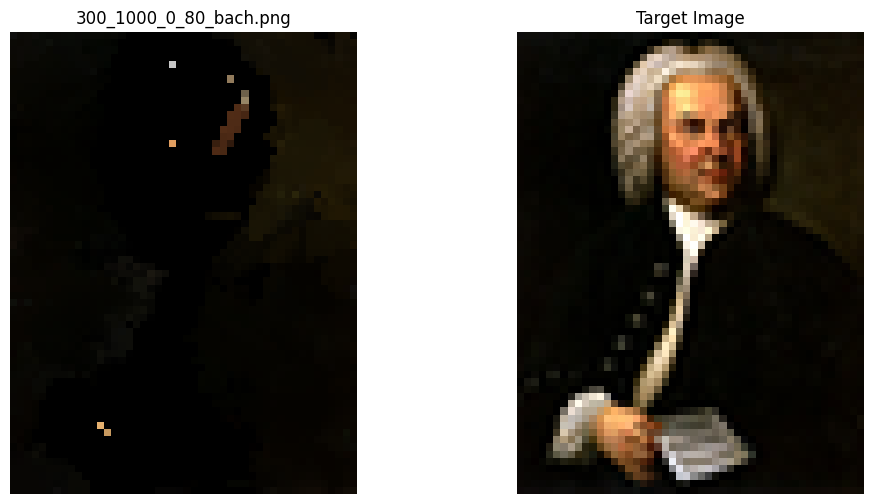

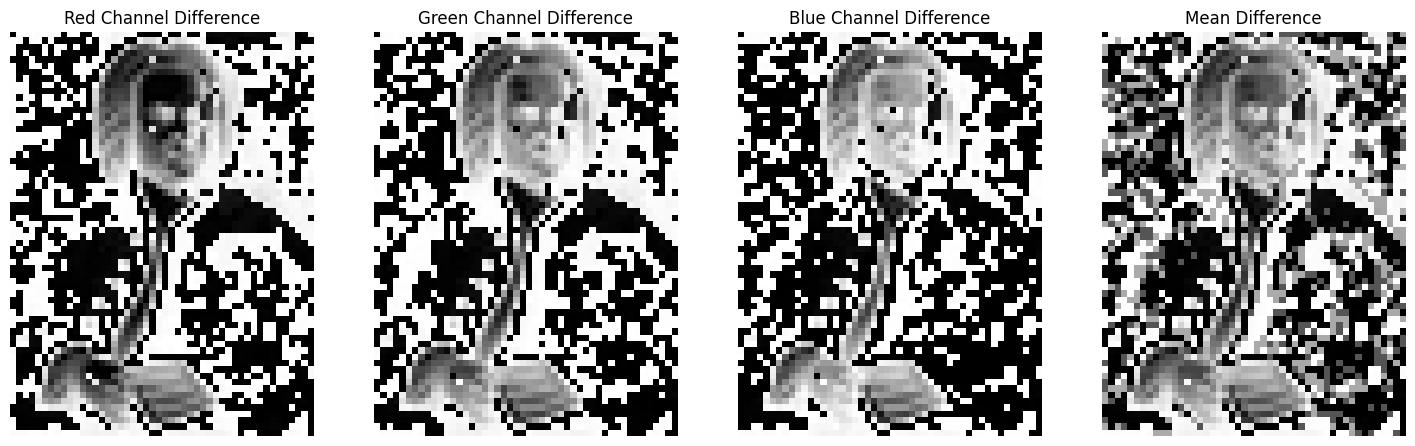

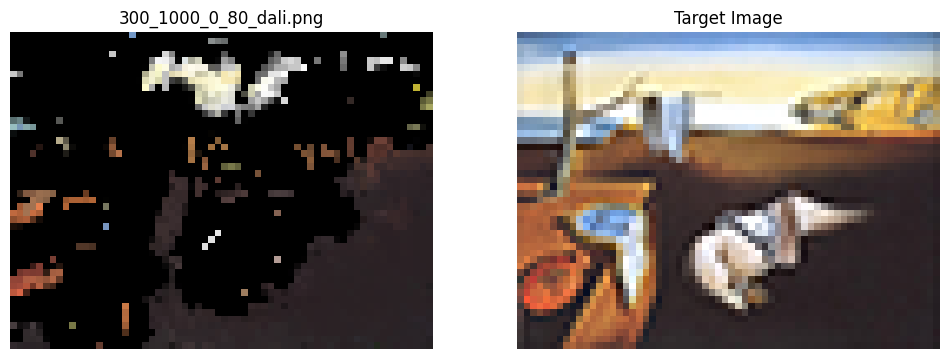

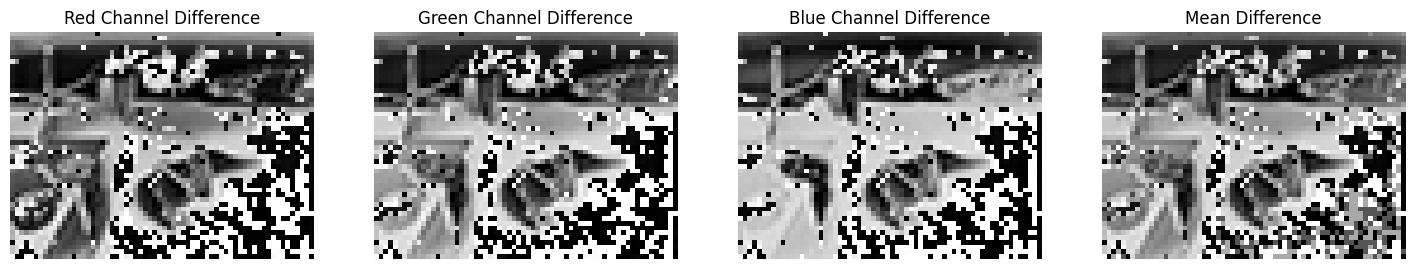

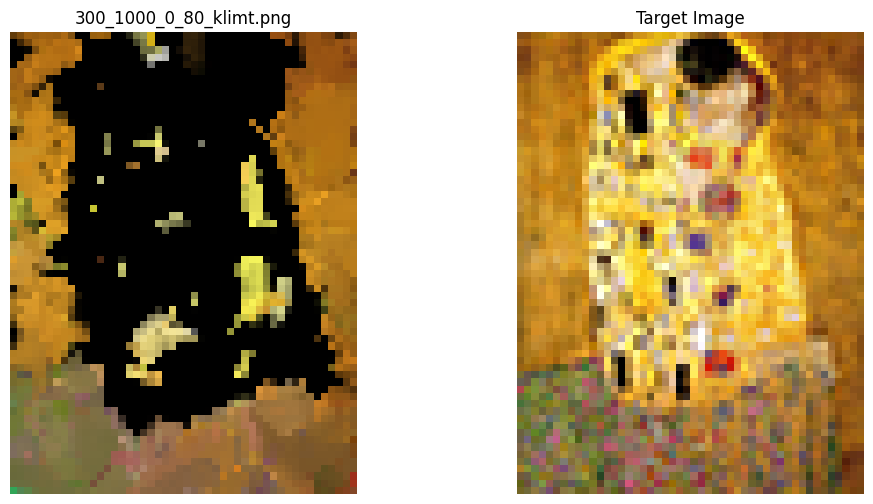

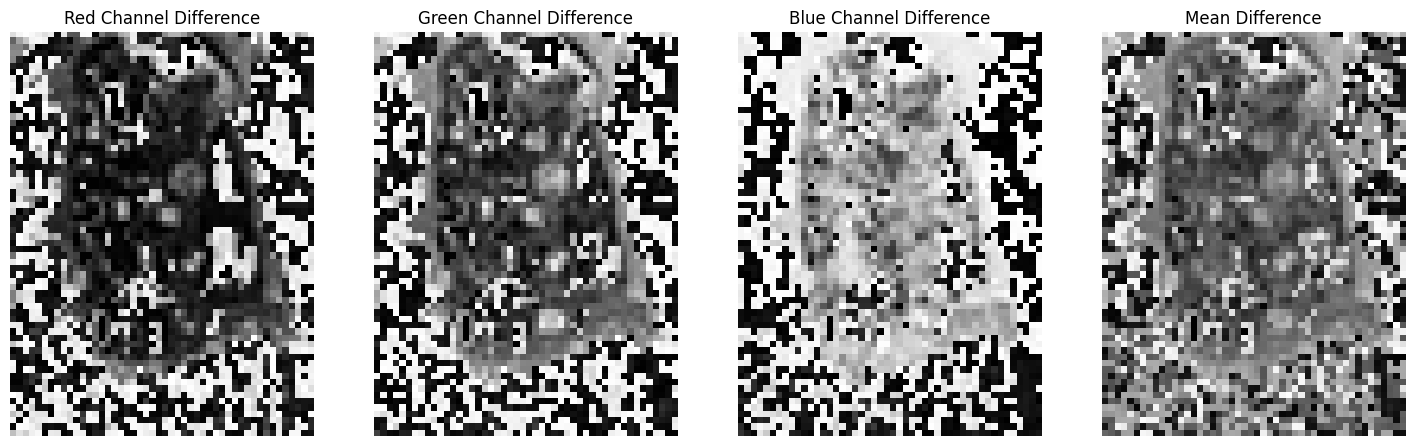

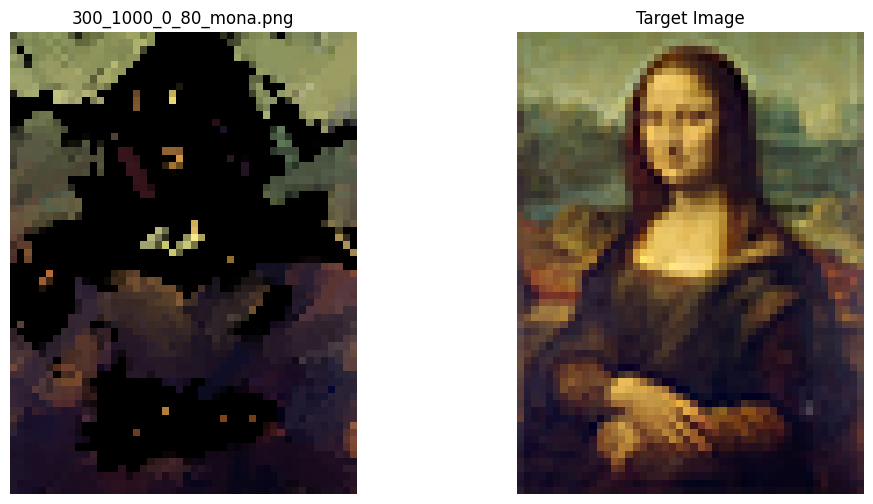

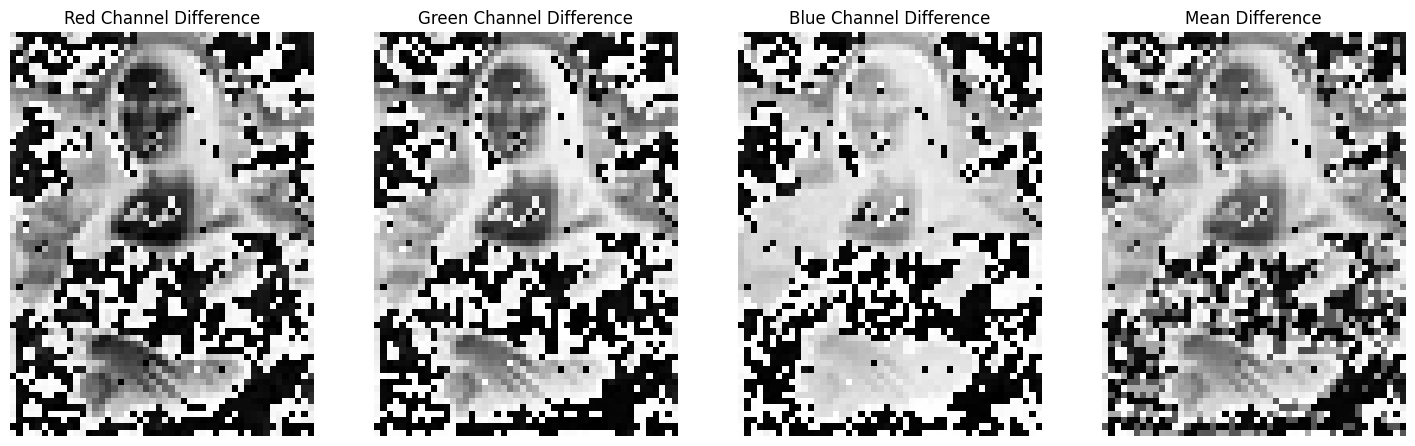

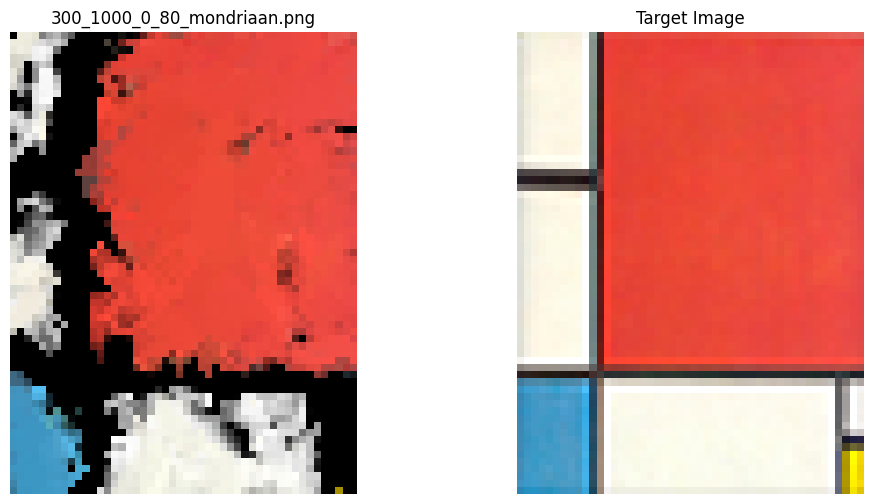

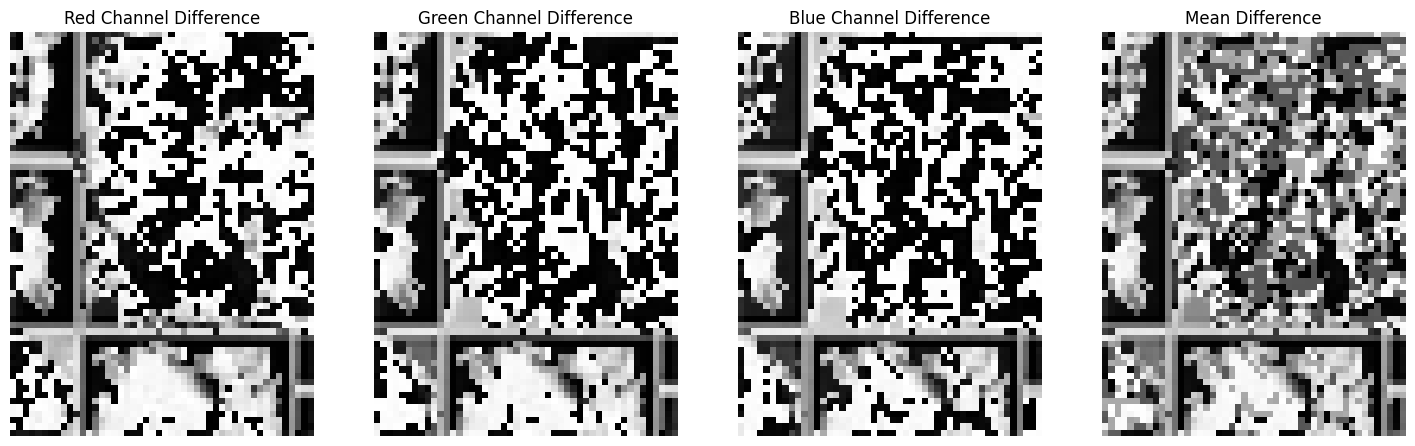

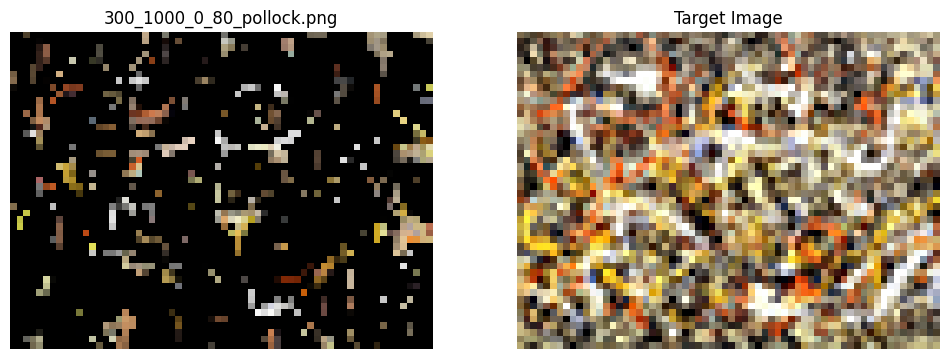

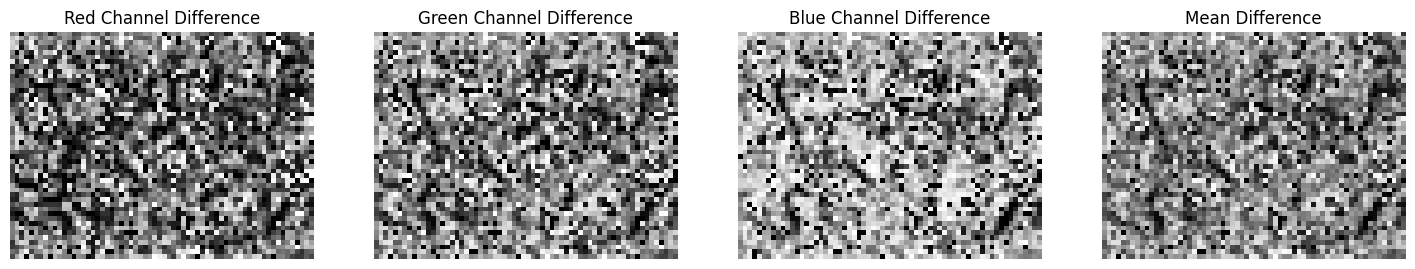

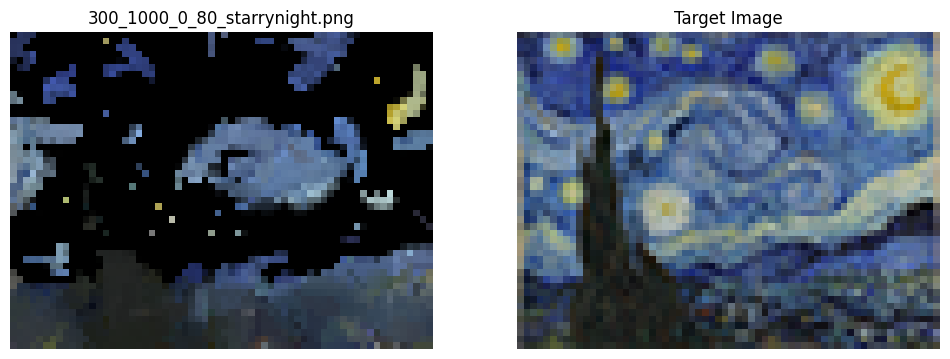

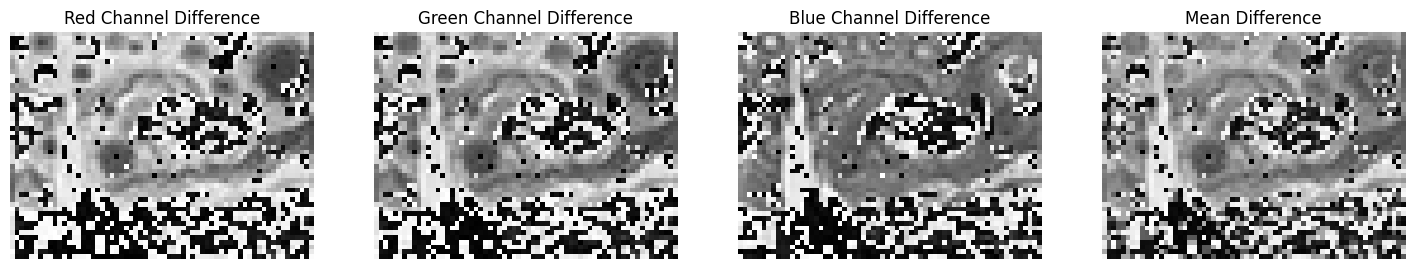

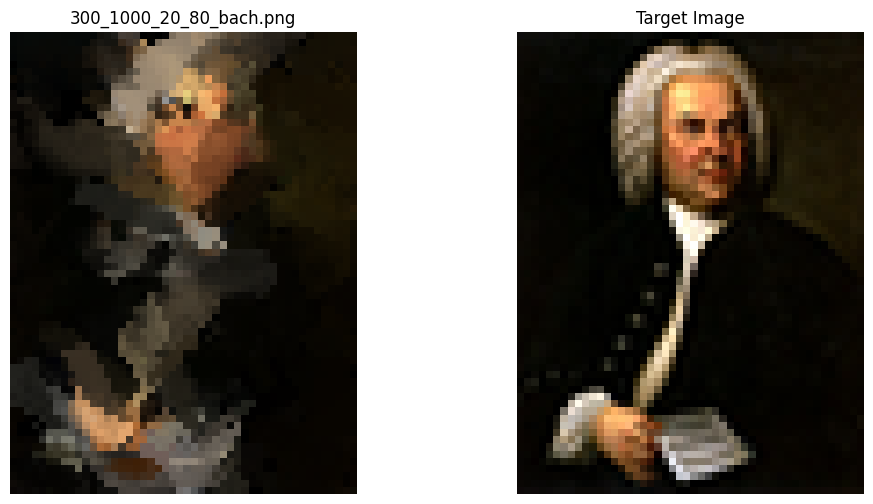

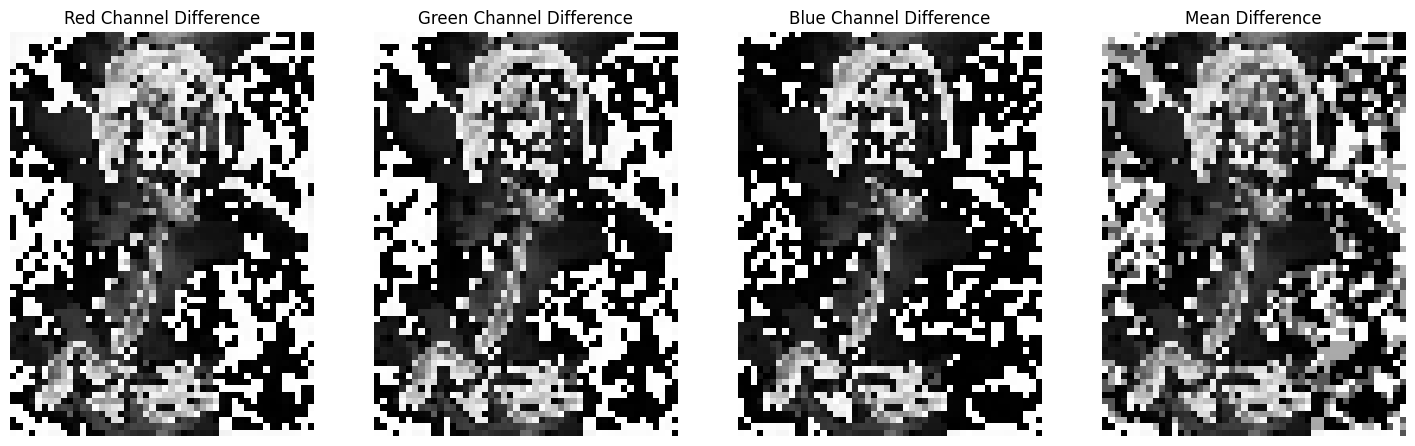

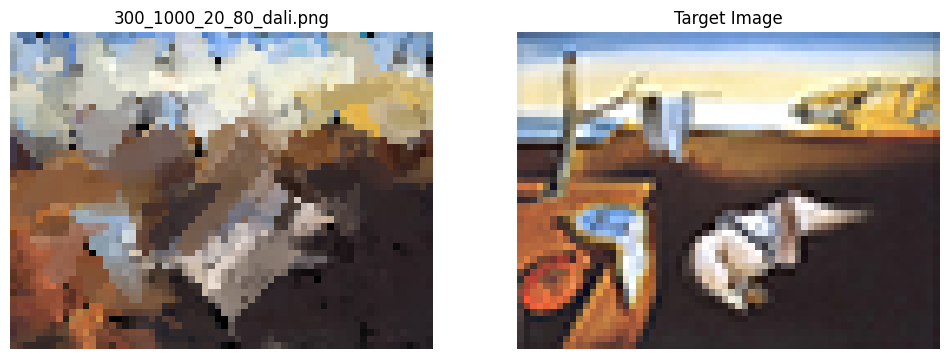

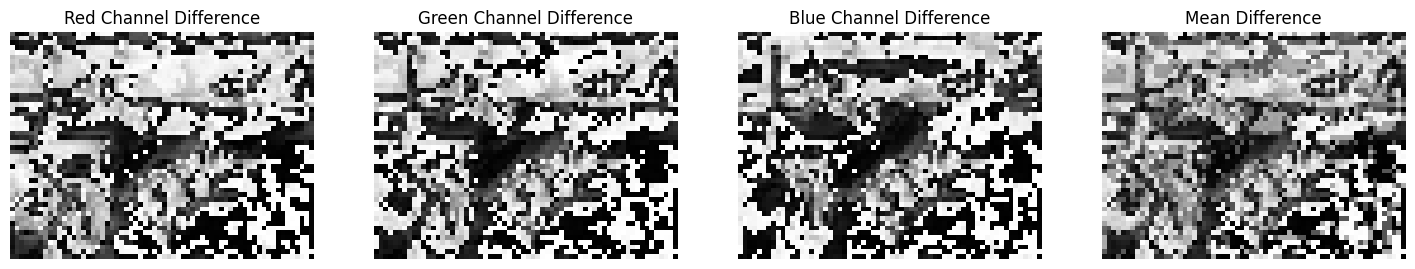

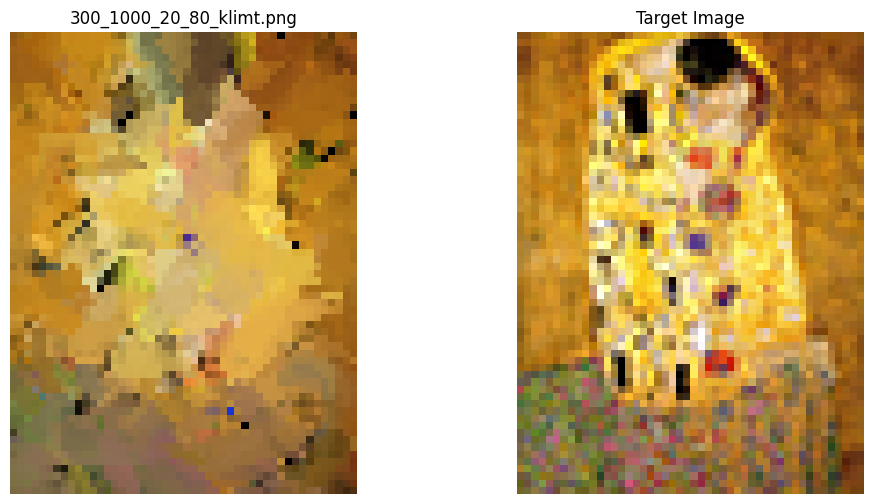

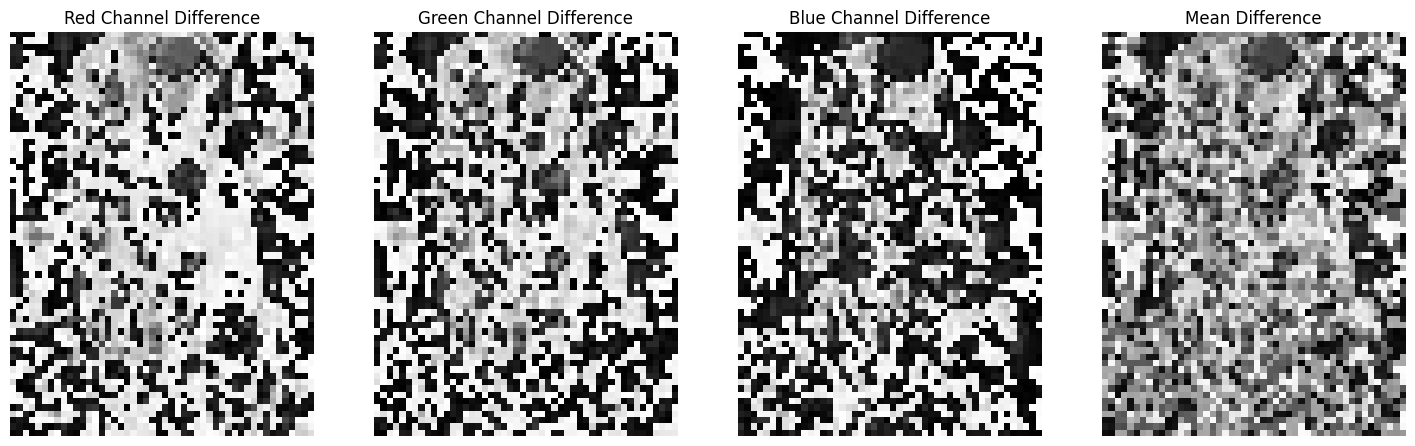

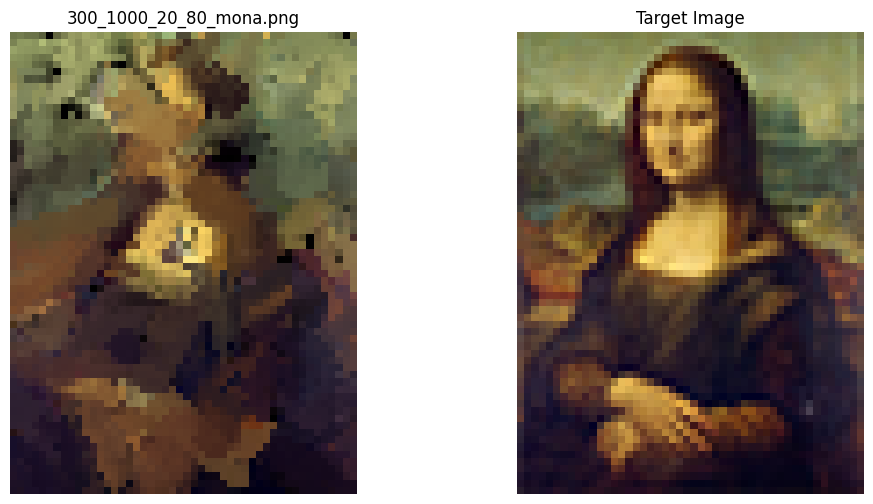

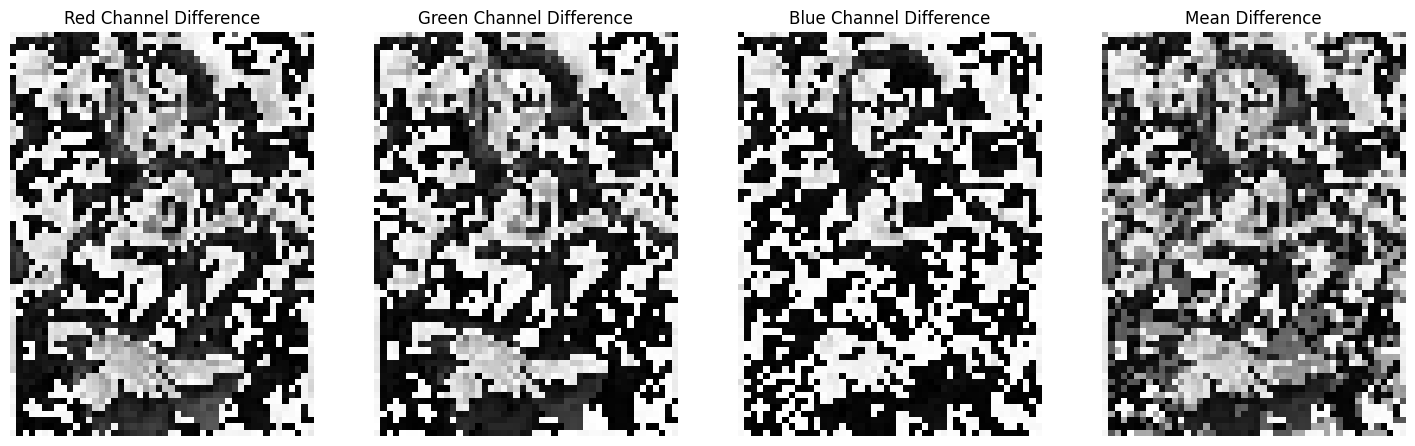

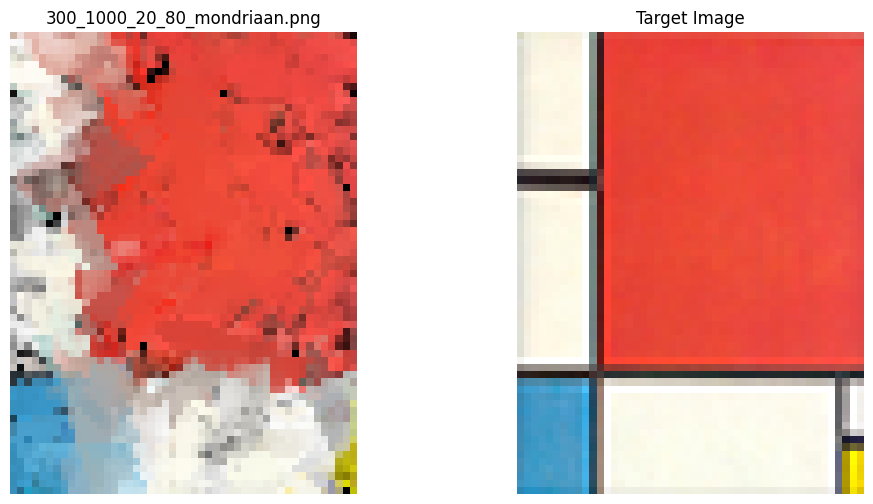

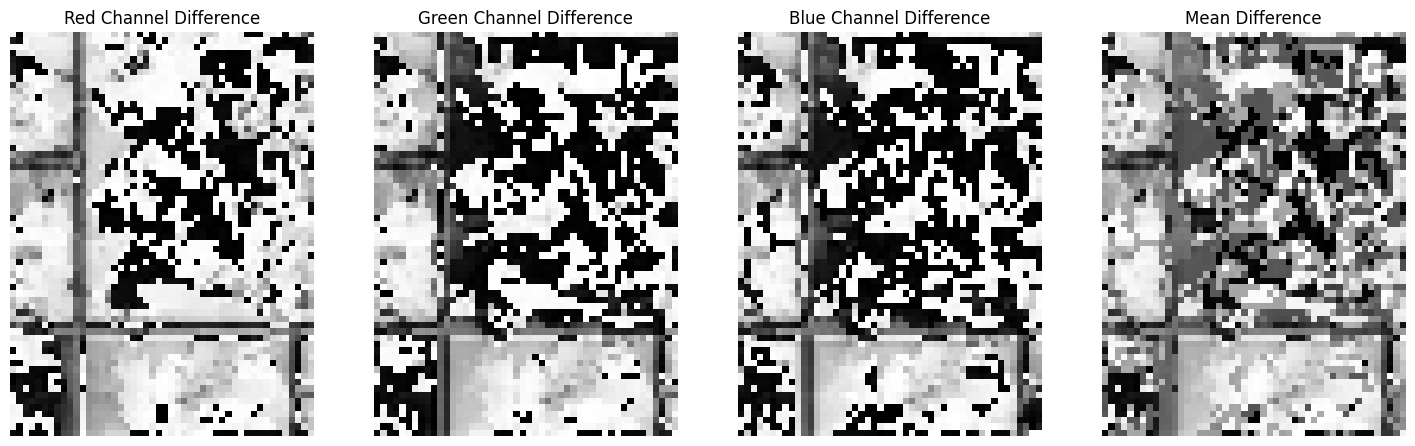

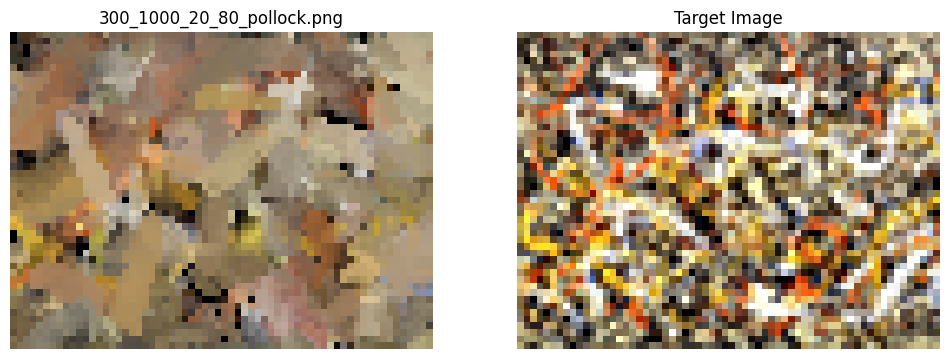

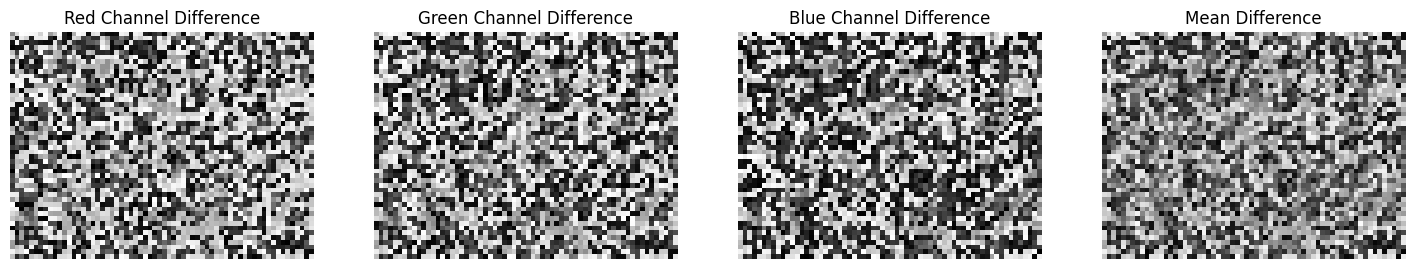

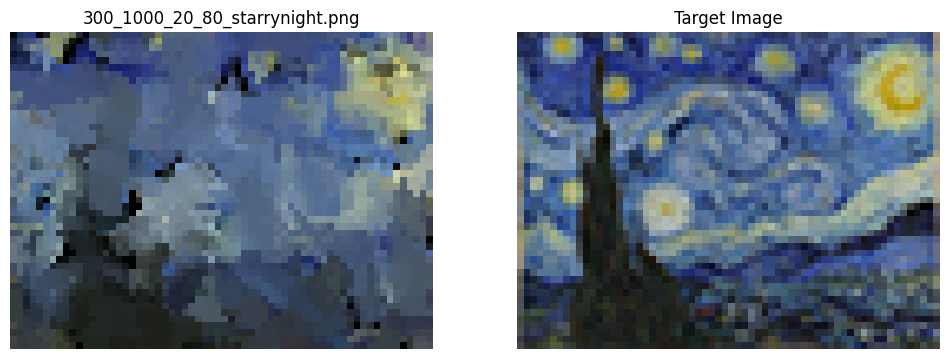

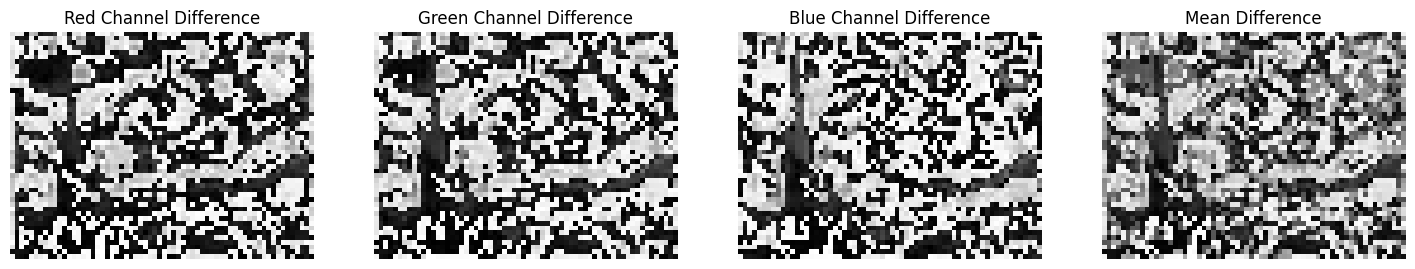

In [9]:
for file_name in os.listdir("output/"):
    if file_name.lower().endswith(('.png')):
        out = read_image(f"output/{file_name}")
        target = read_image(f"instancias/{file_name.split('_')[-1]}")

        # Show output and target side by side
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].imshow(out)
        axs[0].set_title(file_name)
        axs[0].axis("off")
        axs[1].imshow(target)
        axs[1].set_title("Target Image")
        axs[1].axis("off")
        plt.show()

        diff = np.abs(out - target)

        # Show difference by channel and the mean difference
        fig, axs = plt.subplots(1, 4, figsize=(18, 6))
        axs[0].imshow(diff[:,:,0], cmap='gray')
        axs[0].set_title("Red Channel Difference")
        axs[0].axis("off")
        axs[1].imshow(diff[:,:,1], cmap='gray')
        axs[1].set_title("Green Channel Difference")
        axs[1].axis("off")
        axs[2].imshow(diff[:,:,2], cmap='gray')
        axs[2].set_title("Blue Channel Difference")
        axs[2].axis("off")
        mean_diff = np.mean(diff, axis=2)
        axs[3].imshow(mean_diff, cmap='gray')
        axs[3].set_title("Mean Difference")
        axs[3].axis("off")
        plt.show()